# Introdução ao Keras - Bostong House Pricing

Semelhante ao notebook anterior, mas agora utilizando a base boston_housing.

In [38]:
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

train_data.shape, train_targets.shape, test_data.shape, test_targets.shape

((404, 13), (404,), (102, 13), (102,))

In [33]:
import numpy as np
from tensorflow import keras
from keras import layers
from tensorflow.keras.utils import to_categorical

X_train = train_data
X_test = test_data
y_train = train_targets
y_test = test_targets

In [48]:
from sklearn.model_selection import train_test_split

model = keras.Sequential([layers.Dense(64, activation="relu"),
                          layers.Dense(64, activation="relu"),
                          layers.Dense(1, activation="linear")]) #linear é default

model.compile(optimizer="rmsprop",
              loss="mse",
              metrics=["mae"])#loss com mse - mae min absolute error

#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.9)

#separando as bases de treino de validação

X_val = X_train[:300]
partial_x_train = X_train[300:]

y_val = y_train[:300]
partial_y_train = y_train[300:]


history = model.fit(partial_x_train, partial_y_train, 
                    epochs=20, batch_size=512, 
                    validation_data=(X_val, y_val))

result = model.evaluate(X_test, y_test)
print(result)

Epoch 1/20
1/1 [==============================] - 1s 643ms/step - loss: 2077.5454 - mae: 44.6223 - val_loss: 209.9031 - val_mae: 11.2460
Epoch 2/20
1/1 [==============================] - 0s 43ms/step - loss: 192.3243 - mae: 11.2410 - val_loss: 97.5576 - val_mae: 7.2321
Epoch 3/20
1/1 [==============================] - 0s 47ms/step - loss: 117.0571 - mae: 8.2995 - val_loss: 84.8111 - val_mae: 6.8186
Epoch 4/20
1/1 [==============================] - 0s 49ms/step - loss: 97.6226 - mae: 7.5848 - val_loss: 74.5085 - val_mae: 6.5165
Epoch 5/20
1/1 [==============================] - 0s 43ms/step - loss: 88.0936 - mae: 6.9942 - val_loss: 69.7161 - val_mae: 6.3886
Epoch 6/20
1/1 [==============================] - 0s 43ms/step - loss: 83.7913 - mae: 6.7368 - val_loss: 67.2237 - val_mae: 6.3309
Epoch 7/20
1/1 [==============================] - 0s 45ms/step - loss: 81.4589 - mae: 6.6354 - val_loss: 65.6199 - val_mae: 6.2949
Epoch 8/20
1/1 [==============================] - 0s 41ms/step - loss: 80.

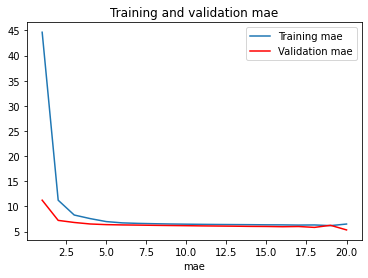

In [49]:
import matplotlib.pyplot as plt

def PrintHistory(history, function="mse"): #loss ou accuracy
    history_dict = history.history
    loss_values = history_dict[function]
    val_loss_values = history_dict["val_"+function]
    epochs = range(1, len(loss_values)+1)
    
    plt.plot(epochs, loss_values, "-", label="Training "+function) #bo=blue o
    plt.plot(epochs, val_loss_values, "r", label="Validation "+function)
    plt.title("Training and validation "+function)
    plt.xlabel("Epochs")
    plt.xlabel(function)
    plt.legend()
    plt.show()

PrintHistory(history=history, function="mae")
#PrintHistory(history=history, function="accuracy")

### Melhorando a solução

Observe que o grafico da validação obtido acima acompanha o grafico do treino. Isso significa que não conseguimos atingir o ponto em que começa a dar overfiting. Ou seja, não conseguimos provar que não saímos do underfiting. Então, precisamos criar algumas estratégias para tentar, fazendo crossvalidation, melhorar a validação. Graficamente, isso significa que precisamos encontrar o ponto em que os graficos começam a divergir, semelhante à "boca do jacaré", encontrado nos notebooks anteriores.

Aplicando uma solução para separar por K-Folds e utilizar cross-validation, pois a quantidade de dados da base é muito pequena.

In [107]:
from tensorflow import keras
from tensorflow.keras import layers

def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(64, activation="relu"),
        layers.Dense(1),
    ])
        
    opt = keras.optimizers.RMSprop(learning_rate=0.005)
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])
    return model

In [108]:
import numpy as np

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

k = 4
num_val_samples = len(train_data) // k
num_epochs = 50
all_scores = []
TESTE = False

if TESTE:
    for i in range(k):
        print(f"Processing fold #{i}")
        val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
        val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
        partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                            train_data[:(i+1) * num_val_samples]],
                                            axis=0)
        partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[:(i+1) * num_val_samples]],
                                            axis=0)
        model = build_model()
        model.fit(partial_train_data, partial_train_targets,
                epochs=num_epochs, batch_size=16, verbose=0)
        #avaliando o resultado do evaluate
        val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
        all_scores.append(val_mae)

    all_scores, np.mean(all_scores)

In [109]:
#num_epochs = 500
num_epochs = 50
all_mae_histories = []
loss_all_mae_histories = []
for i in range(k):
    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[:(i+1) * num_val_samples]],
                                         axis=0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                         train_targets[:(i+1) * num_val_samples]],
                                         axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    
    loss_mae_history = history.history["mae"]
    loss_all_mae_histories.append(loss_mae_history)
    loss_average_mae_history = [np.mean([x[i] for x in loss_all_mae_histories]) for i in range(num_epochs)]
    
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)
    average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3


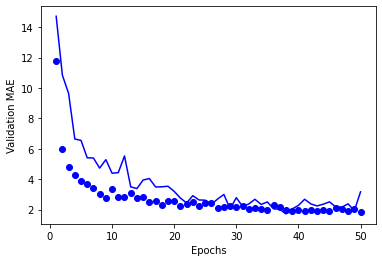

In [110]:
import matplotlib.pyplot as plt

#plt.plot(epochs, loss_values, "-", label="Training "+function) #bo=blue o
plt.plot(range(1,len(loss_average_mae_history)+1), loss_average_mae_history, "bo")
plt.plot(range(1,len(average_mae_history)+1), average_mae_history, "b")
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()


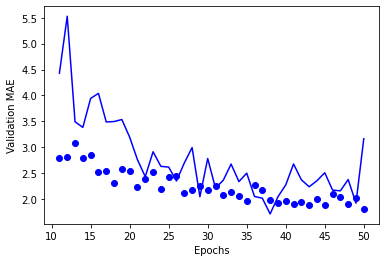

In [111]:
begin = 10
loss_truncated_mae_history = loss_average_mae_history[begin:]
truncated_mae_history = average_mae_history[begin:]

plt.plot(range(begin+1,len(loss_average_mae_history)+1), loss_truncated_mae_history, "bo", label="Trunc. Training mse")
plt.plot(range(begin+1,len(average_mae_history)+1), truncated_mae_history, "b", label="Trunc. Validation mse")
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

Ainda não consegui o grafico mostrar divergindo. Testando batchnormalization e novas camadas, mesmo assim não deu.